In [1]:
# Import necessary dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the datafile
df = pd.read_csv('digit_data.csv')
print('Size of the dataframe: ',df.shape)

Size of the dataframe:  (42000, 785)


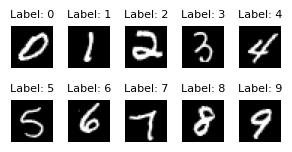

In [3]:
# Visualize images from each label
random_rows = df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)

fig, axes = plt.subplots(2, 5, figsize=(3, 3))

for i, ax in enumerate(axes.flat):
    image_data = random_rows.iloc[i, 1:].values
    image = np.array(image_data).reshape(28,28)
    label = random_rows.iloc[i, 0]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}", fontsize=8)
    ax.axis('off')

plt.subplots_adjust(wspace=.2, hspace=-.8)
plt.tight_layout()
plt.show()

In [4]:
# Convert df to numpy array
df_arr = np.array(df)

In [5]:
# Shuffle the array
np.random.seed(42)
np.random.shuffle(df_arr)

In [6]:
# Create the test set
test_set = df_arr[:1000,:]

# Transpose the data
test_set = test_set.T

# Split the image (normalize the image) and it's label
test_image = test_set[1:,:]/255
test_label = test_set[0,:]

print('Shape of test image: ',test_image.shape)

Shape of test image:  (784, 1000)


In [7]:
# Create the train set
train_set = df_arr[1000:,:]

# Transpose the data
train_set = train_set.T

# Split the image (normalize the image) and it's label
train_image = train_set[1:,:]/255
train_label = train_set[0,:]

print('Shape of train image: ',train_image.shape)

Shape of train image:  (784, 41000)


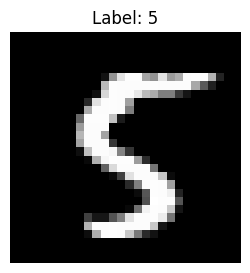

In [8]:
# Plot the random image from the train set
idx = np.random.randint(1000, 42000)
image = train_image[:,idx].reshape(28,28)
label = train_label[idx]
plt.figure(figsize=(3,3))
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}", fontsize=12)
plt.axis('off')
plt.show()

In [9]:
# Define the size parameters
input_size = 784
hidden1_size = 10
hidden2_size = 10
output_size = 10

In [10]:
# Function to initialize the parameters (Xavier initialization)
def initialize_parameters():
    np.random.seed(42)
    
    W0 = np.random.randn(hidden1_size, input_size) * np.sqrt(2 / (input_size + hidden1_size))
    b0 = np.zeros((hidden1_size, 1))
    
    W1 = np.random.randn(hidden2_size, hidden1_size) * np.sqrt(2 / (hidden1_size + hidden2_size))
    b1 = np.zeros((hidden2_size, 1))
    
    W2 = np.random.randn(output_size, hidden2_size) * np.sqrt(2 / (hidden2_size + output_size))
    b2 = np.zeros((output_size, 1))
    
    return W0, b0, W1, b1, W2, b2

In [11]:
# Define function for tanh
def tanh_activation(x):
    return np.tanh(x)

In [12]:
# Define function for derivative of tanh
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

In [13]:
# Define sigmoid activation
def sigmoid_activation(x):
    return 1 / (1 + np.exp(-x))

In [14]:
# Define sigmoid derivative
def sigmoid_derivative(x):
    sig = sigmoid_activation(x)
    return sig * (1 - sig)

In [15]:
# Define the softmax function
def softmax_activation(x):
    # Subtraction for numerical stability
    temp = np.exp(x - np.max(x))
    return temp / np.sum(temp, axis = 0)

In [16]:
def batch_normalize(Z, epsilon=1e-8):
    mean = np.mean(Z, axis=1, keepdims=True)
    variance = np.var(Z, axis=1, keepdims=True)
    normalized = (Z - mean) / np.sqrt(variance + epsilon)
    return normalized

In [17]:
# Function to implement forward propagation
def forward_propagation(W0, b0, W1, b1, W2, b2, A0):
    # Calculate the input to the hidden layer (Z1)
    Z1 = np.dot(W0, A0) + b0
    Z1 = batch_normalize(Z1)
    A1 = tanh_activation(Z1)

    # Calculate the input to the hidden layer (Z2)
    Z2 = np.dot(W1, A1) + b1
    A2 = sigmoid_activation(Z2)

    # Calculate the input to the output layer (Z3)
    Z3 = np.dot(W2, A2) + b2
    A3 = softmax_activation(Z3)

    return Z1, A1, Z2, A2, Z3, A3

In [18]:
def one_hot_label(Y):
    m = Y.shape[0]
    one_hot_encoded = np.zeros((10, m))
    one_hot_encoded[Y, np.arange(m)] = 1
    return one_hot_encoded

In [19]:
def backward_propagation(Z1, A1, Z2, A2, Z3, A3, W0, W1, W2, A0, Y, lambd):
    m = Y.shape[0]
    #r = (lambd / m)
    r = 0
    # Encode the label
    Y = one_hot_label(Y)

    # Derivative of cost with respect to output
    dZ3 = A3 - Y

    # Compute the gradient of the cost with respect to output layer
    dW2 = (1/m) * np.dot(dZ3, A2.T) + r * W2
    db2 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)

    # Compute the derivative of the activation function for the second hidden layer
    dZ2 = np.dot(W2.T, dZ3) * sigmoid_derivative(Z2)

    # Gradient of cost with respect to second hidden layer
    dW1 = (1/m) * np.dot(dZ2, A1.T) + r * W1  # Corrected this line
    db1 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Compute the derivative of the activation function for the first hidden layer
    dZ1 = np.dot(W1.T, dZ2) * tanh_derivative(Z1)

    # Gradient of cost with respect to first hidden layer
    dW0 = (1/m) * np.dot(dZ1, A0.T) + r * W0
    db0 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW0, db0, dW1, db1, dW2, db2

In [20]:
# Function to update the parameters
def update_parameters(W0, b0, W1, b1, W2, b2, dW0, db0, dW1, db1, dW2, db2, alpha):
    # Update the parameters using gradient descent
    W0 -= alpha * dW0
    b0 -= alpha * db0

    W1 -= alpha * dW1
    b1 -= alpha * db1

    W2 -= alpha * dW2
    b2 -= alpha * db2

    return W0, b0, W1, b1, W2, b2

In [21]:
def obtain_prediction(x):
    # If x is a single vector
    if len(x.shape) == 1:
        return np.argmax(x)

    # If x is an array of vectors
    else:
        return np.apply_along_axis(np.argmax, axis=0, arr=x)

In [22]:
# Obtain the accuracy score
def accuracy_score(predicted, actual):
    correct = np.sum(predicted == actual)
    total = predicted.shape
    return correct / total

In [23]:
# Function to implement gradient descent
def gradient_descent(A0, Y, alpha, epoch, lambd):
    W0, b0, W1, b1, W2, b2 = initialize_parameters()
    accuracy_list = []

    for i in range(1, epoch + 1):
        Z1, A1, Z2, A2, Z3, A3 = forward_propagation(W0, b0, W1, b1, W2, b2, A0)
        dW0, db0, dW1, db1, dW2, db2 = backward_propagation(Z1, A1, Z2, A2, Z3, A3, W0, W1, W2, A0, Y, lambd)
        W0, b0, W1, b1, W2, b2 = update_parameters(W0, b0, W1, b1, W2, b2, dW0, db0, dW1, db1, dW2, db2, alpha)

        predicted = obtain_prediction(A3)
        accuracy = accuracy_score(predicted, Y)
        accuracy_list.append((i, accuracy))

        if i % 5 == 0:
            print(f"Iteration {i}, Accuracy: {accuracy}")

    return W0, b0, W1, b1, W2, b2, accuracy_list

In [24]:
def make_predictions(W0, b0, W1, b1, W2, b2, A0):
    _, _, _, _, _, A3 = forward_propagation(W0, b0, W1, b1, W2, b2, A0)
    prediction = obtain_prediction(A3)
    return prediction

In [25]:
def test_prediction(W0, b0, W1, b1, W2, b2, idx):
    image = test_image[:,idx].reshape(28, 28)
    actual_label = test_label[idx]
    prediction = make_predictions(W0, b0, W1, b1, W2, b2, test_image[:,idx].reshape(-1,1))

    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {prediction}, Actual: {actual_label}')
    plt.axis('off')
    plt.show()

In [26]:
alpha = 0.07
epoch = 1000
lambd = 0.01
W0, b0, W1, b1, W2, b2, accuracy_list = gradient_descent(train_image, train_label, alpha, epoch, lambd)

Iteration 5, Accuracy: [0.08990244]
Iteration 10, Accuracy: [0.09046341]
Iteration 15, Accuracy: [0.09756098]
Iteration 20, Accuracy: [0.11231707]
Iteration 25, Accuracy: [0.13612195]
Iteration 30, Accuracy: [0.1687561]
Iteration 35, Accuracy: [0.20804878]
Iteration 40, Accuracy: [0.24665854]
Iteration 45, Accuracy: [0.28246341]
Iteration 50, Accuracy: [0.31263415]
Iteration 55, Accuracy: [0.33485366]
Iteration 60, Accuracy: [0.35241463]
Iteration 65, Accuracy: [0.36685366]
Iteration 70, Accuracy: [0.3795122]
Iteration 75, Accuracy: [0.38970732]
Iteration 80, Accuracy: [0.399]
Iteration 85, Accuracy: [0.40795122]
Iteration 90, Accuracy: [0.41478049]
Iteration 95, Accuracy: [0.4214878]
Iteration 100, Accuracy: [0.42834146]
Iteration 105, Accuracy: [0.4337561]
Iteration 110, Accuracy: [0.43904878]
Iteration 115, Accuracy: [0.44378049]
Iteration 120, Accuracy: [0.44809756]
Iteration 125, Accuracy: [0.45156098]
Iteration 130, Accuracy: [0.45480488]
Iteration 135, Accuracy: [0.458]
Iteratio

Epoch : 1000, Maximum Accuracy: 72.52%


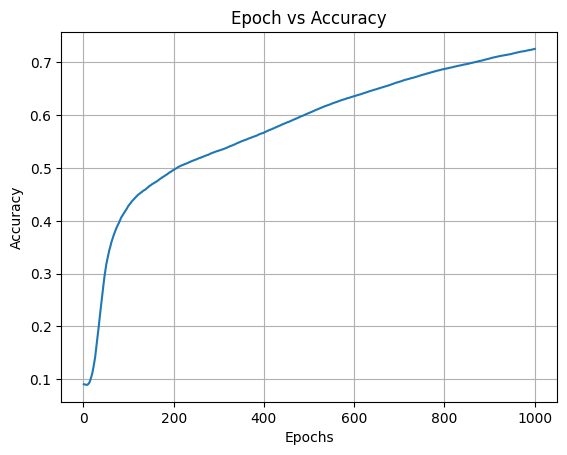

In [27]:
# Extract epoch numbers and accuracy values
epochs = [entry[0] for entry in accuracy_list]
accuracy_values = [entry[1][0] for entry in accuracy_list]

# Find the maximum accuracy and its index
max_accuracy = max(accuracy_values)
max_accuracy_epoch = epochs[accuracy_values.index(max_accuracy)]

# Print the maximum accuracy and its epoch
print(f"Epoch : {max_accuracy_epoch}, Maximum Accuracy: {max_accuracy*100:.2f}%")


# Plot the epoch versus accuracy curve
plt.plot(epochs, accuracy_values)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.grid()
plt.show()

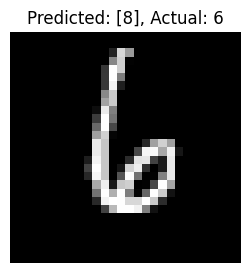

In [31]:
test_prediction(W0, b0, W1, b1, W2, b2, np.random.randint(0, 1000))

In [29]:
# Accuracy score on the test set
_, _, _, _, _, A3 = forward_propagation(W0, b0, W1, b1, W2, b2, test_image)
prediction = obtain_prediction(A3)
accuracy = accuracy_score(prediction, test_label)
print(f'Accuracy Score from test set: {"{:.2%}".format(float(accuracy))}', )

Accuracy Score from test set: 74.10%
